# [OPT11] - Real or Not ? NLP with Disaster tweets 

## Importation des bibliothèques

In [78]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Importation des données

On importe d'abord les fichiers locaux vers google colab.

In [ ]:
from google.colab import files

dataTmp1 = files.upload() # pour train.csv
dataTmp2 = files.upload() # pour test.csv

Saving train.csv to train.csv


Saving test.csv to test.csv


Kaggle propose deux bases de données, un pour l'entraînement et un autre pour le test.  
Dans train.csv, on a pour chaque entrée, 5 valeurs : un identifiant unique, un mot-clé qui caractérise le tweet, le lieu du tweet, le texte du tweet, et finalement la cible qui indique si le tweet en question annonce un réel désastre ou non.  
Dans test.csv, on a les 4 premières valeurs, mais il manque la cible.  
C'est pourquoi, on va uniquement utiliser 'train.csv' par la suite.

In [79]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

In [3]:
trainset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
testset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print("Nombre de tweets dans train.csv : ",len(trainset))

Nombre de tweets dans train.csv :  7613


## Manipulation et visualisation des données

### Suppression des doublons

On utilise pandas.DataFrame.drop_duplicates pour enlever les tweets qui ont exactements le même texte et la même cible qu'un tweet précédent (on ne conserve que la première occurence du tweet) :

In [80]:
data = trainset.drop_duplicates(subset=['text', 'target'], keep='first')
print(len(data))

7521


92 tweets ont été enlevé au total (7613 entrées au départ et 7521 après la suppression des doublons).

### Visualisation des cellules vides dans la DataFrame

On vérifie le nombre de cellules vides dans nos données :

In [7]:
data.isnull().sum() 
# isnull() renvoie un True si la cellule est vide et False dans le cas contraire
# il suffit de sommer pour obtenir le nombre de True pour une catégorie et donc connaître le nombre de cellule vide

id             0
keyword       56
location    2490
text           0
target         0
dtype: int64

### Répartition du nombre de vrais tweet et de faux tweet

0 indique que c'est un faux message d'alerte tandis que 1 indique un vrai.

In [81]:
data.target.value_counts()

0    4315
1    3206
Name: target, dtype: int64

In [9]:
print('Pourcentage du nombre de vrais tweet par rapport au nombre total de tweet : ', 3206/(3206+4315))

Pourcentage du nombre de vrais tweet par rapport au nombre total de tweet :  0.4262731019811195


### Calcule de la longueur des textes

In [14]:
data.insert(3, 'text_length', data.text.apply(lambda x: len(x.split())))

In [15]:
data.head()

,id,keyword,location,text_length,text,target
0,1,NaN,NaN,13,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,7,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,22,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,8,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,16,Just got sent this photo from Ruby #Alaska as ...,1


### Tokenization du texte

In [82]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    # remove links and remove words containing number
    string = re.sub('http?://\S+|www\.\S+', '', string)
    string = re.sub('\w*\d\w*', '', string)
    
    if tolower:
        string = string.lower()
    return string.strip()

text = [clean_str(x).split() for x in data.text]

In [83]:
text[0]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

### Suppression des stopwords

Les stopwords sont les mots qui n'ajoutent pas beaucoup de sens dans une phrase, ce sont des mots très couramment utilisés et on peut se permettre de les supprimer.  
On utilise la bibliothèque nltk pour récupérer ces stopwords :

In [14]:
import nltk
nltk.download() # télécharge les données nécéssaires pour utiliser nltk

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [18]:
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
# removing stopwords
def remove_stopwords(phrase):
    phrase_sans_stopwords = [mot for mot in phrase if mot not in stopwords.words('english')]
    return phrase_sans_stopwords 

In [84]:
text = [remove_stopwords(phrase) for phrase in text]
text[0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

### Lemmatisation des mots

La lemmatisation permet de récupérer d'un mot son lemme.
Ainsi "playing", "plays" et "played" donneront comme lemme : "play"

In [21]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

# lemmatisation de la phrase
def lem_word(phrase):
    return [lem.lemmatize(mot) for mot in phrase]

In [85]:
text = [lem_word(phrase) for phrase in text]
text[0]

['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

### Fonction de perte

On utilise BCELoss comme fonction pour calculer la perte.

In [31]:
loss = nn.BCELoss()

### BERT embedding

In [53]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|███████████████████████████████████████████████████████████████████████| 231508/231508 [00:01<00:00, 203702.62B/s]


In [147]:
# from tokenized sentences to string 
text_str = [' '.join(sentence) for sentence in text]
# add special token for bert
marked_text_str = [ "[CLS] " + sentence + " [SEP]" for sentence in text_str]

In [148]:
tokenized_text = [tokenizer.tokenize(sentence) for sentence in marked_text_str]
indexed_tokens = [tokenizer.convert_tokens_to_ids(tokenized_sentence) for tokenized_sentence in tokenized_text]

In [200]:
index_train, index_dev, label_train, label_dev = train_test_split(indexed_tokens, list(data.target), test_size=1/4, random_state=123)

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [168]:
def bert_embedding_from_tokenized_sentence(model, indexed_sentence):
    '''Transform a list of word tokens to a tensor of the word embeddings
    
    Args:
        model : Bert model used for the word embeddings
        indexed_sentence (List[int]): a list of index representing a sentence
        
    Returns:
        (torch.Tensor): word embedding of each word in indexed_sentence
    '''
    
    # size (1,length of sentence)
    token_tensor = torch.tensor([indexed_sentence])
    segment_tensor = torch.tensor([[1]*len(indexed_sentence)])
    
    with torch.no_grad():

        outputs = model(token_tensor, segment_tensor)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
    
    # list to torch.Tensor
    # size (13, number of sentences, length of sentence, 768) / 13 = number of layers in model / 768 number of features 
    token_embeddings = torch.stack(hidden_states, dim=0)
    # Remove dimension 1, since the number of sentences is fixed to 1
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # permute dimension to (length of sentence, 13, 768)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    
    # SUM THE 4 LAST LAYERS TO GET THE WORD EMBEDDINGS
    token_vecs_sum = []

    for token in token_embeddings:
        # token is a [13 x 768] tensor
        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
        # sum_vec represents the token
        token_vecs_sum.append(sum_vec)
    
    # size (length of sentence, 768)
    return torch.stack(token_vecs_sum, dim=0)

In [164]:
class rnn_classifier2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, last_dim):
        super(rnn_classifier2, self).__init__()
        # RNN Layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)    
        self.proj = nn.Linear(hidden_dim, last_dim)
        self.layer_out = nn.Linear(last_dim, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, inputs):
        # inputs size (1,length of sentence,embedding_dim)
        # size (1,1,hidden_dim)
        _, result = self.rnn(inputs)
        # size (1,hidden_dim)
        result = result.squeeze(0)
        # size (1,last_dim)
        result = F.relu(self.proj(result))
        # size (1,1)
        return self.sig(self.layer_out(result))

In [201]:
numeric_train = [bert_embedding_from_tokenized_sentence(model, token) for token in index_train]
numeric_dev = [bert_embedding_from_tokenized_sentence(model, token) for token in index_dev]

0 	 tensor(3286.8994, grad_fn=<AddBackward0>) 	 0.74481658692185
1 	 tensor(2678.2043, grad_fn=<AddBackward0>) 	 0.7703349282296651
2 	 tensor(2407.2595, grad_fn=<AddBackward0>) 	 0.772461456671983
3 	 tensor(2173.4097, grad_fn=<AddBackward0>) 	 0.7772461456671983
4 	 tensor(2045.5469, grad_fn=<AddBackward0>) 	 0.7740563530037214
5 	 tensor(1802.2274, grad_fn=<AddBackward0>) 	 0.74481658692185
6 	 tensor(1677.2499, grad_fn=<AddBackward0>) 	 0.7618288144603934
7 	 tensor(1553.7068, grad_fn=<AddBackward0>) 	 0.7049441786283892
8 	 tensor(1565.2689, grad_fn=<AddBackward0>) 	 0.7554492291334397
9 	 tensor(1605.9291, grad_fn=<AddBackward0>) 	 0.6299840510366826
10 	 tensor(1714.6669, grad_fn=<AddBackward0>) 	 0.7533227006911217
11 	 tensor(1194.4891, grad_fn=<AddBackward0>) 	 0.7650186071238703
12 	 tensor(1100.2812, grad_fn=<AddBackward0>) 	 0.7522594364699627
13 	 tensor(1049.3817, grad_fn=<AddBackward0>) 	 0.7341839447102605
14 	 tensor(1098.8354, grad_fn=<AddBackward0>) 	 0.768208399787

Text(0.5, 1.0, 'Bert + RNN classifier')

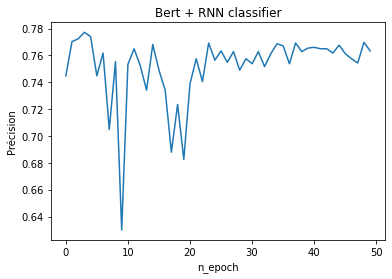

In [202]:
embedding_dim = 768 # dimension from Bert
hidden_dim = 128
last_dim = 32
batch_dim = 128
n_epoch = 50

mlp = rnn_classifier2(embedding_dim, hidden_dim, last_dim)

# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = th.optim.Adam(list(mlp.parameters()))

train_len = len(numeric_train)
dev_len = len(numeric_dev)
acc_list = []

for epoch in range(n_epoch):
    epoch_loss = 0
    
    liste = []
    for i in range(0, train_len, batch_dim): 
        optimizer.zero_grad()
        batch_loss = 0
        # compute the loss between the result of mlp and its true label by passing one by one each sentence
        for j in range(batch_dim) :
            if i+j < train_len :
                output = mlp(numeric_train[i+j].unsqueeze(0))[0] # recupère un tenseur de dim (1,)
                batch_loss += loss(output,th.tensor([label_train[i+j]],dtype = torch.float32))
                liste.append(output)
        
        # add the batch_loss to epoch_loss
        epoch_loss += batch_loss
        
        batch_loss.backward()
        optimizer.step()
    
    # compute dev accuracy
    dev_acc = 0
    count = 0
    for i in range(dev_len):
        if index_dev[i] != []: 
            output = mlp(numeric_dev[i].unsqueeze(0))[0]
            if (output >= 0.5)[0] and label_dev[i] == 1.:
                dev_acc += 1
            if (output < 0.5)[0] and label_dev[i] == 0.:
                dev_acc += 1
        else:
            count += 1
    dev_acc = dev_acc / (dev_len-count)
    acc_list.append(dev_acc)
    print(
        epoch, 
        "\t",
        epoch_loss,
        "\t",
        dev_acc
    )
plt.plot(acc_list)
plt.xlabel("n_epoch")
plt.ylabel("Précision")
plt.title("Bert + RNN classifier")